Selected C:\QGHL\Wave_data\Poruma\East\06\2020-06-05\Poruma_East_2020-06-05T08h30K.hxv


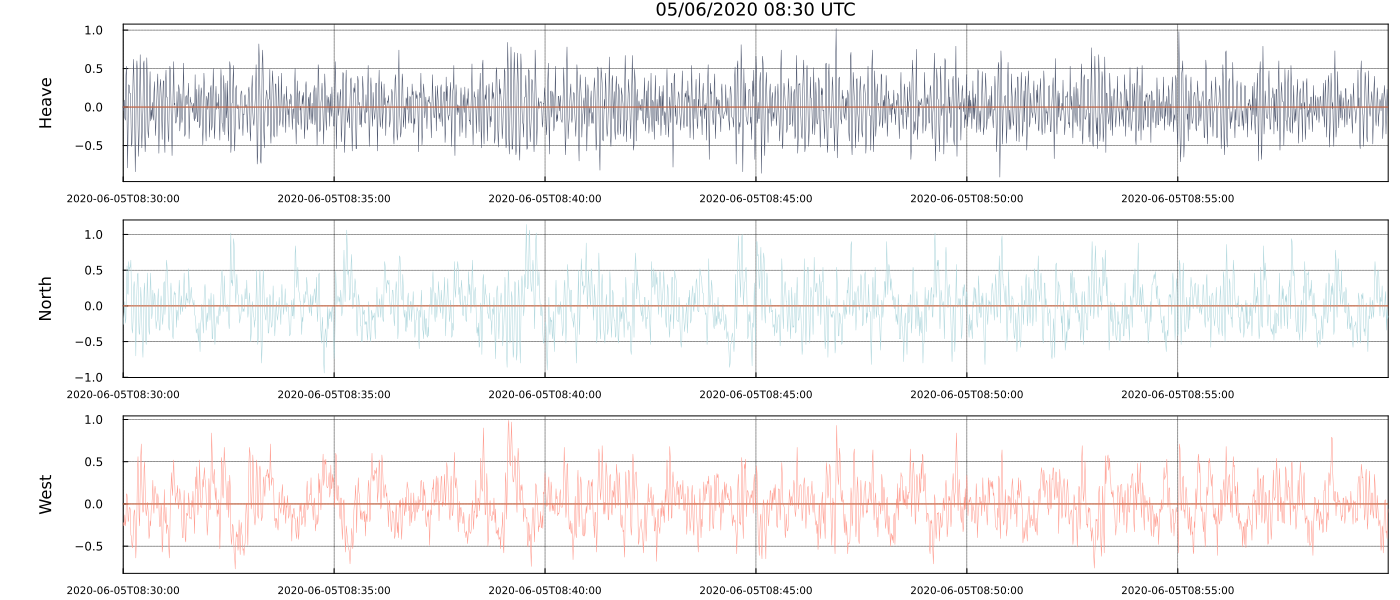

2020-06-05 08:30; Hm0 =  1.06m; Hrms =  0.75m; T01 =  4.54s; T02 =  4.46s; Tc =  4.16s; Tp =  5.19s; Tp5 =  5.05s; Skewness = 0.4759

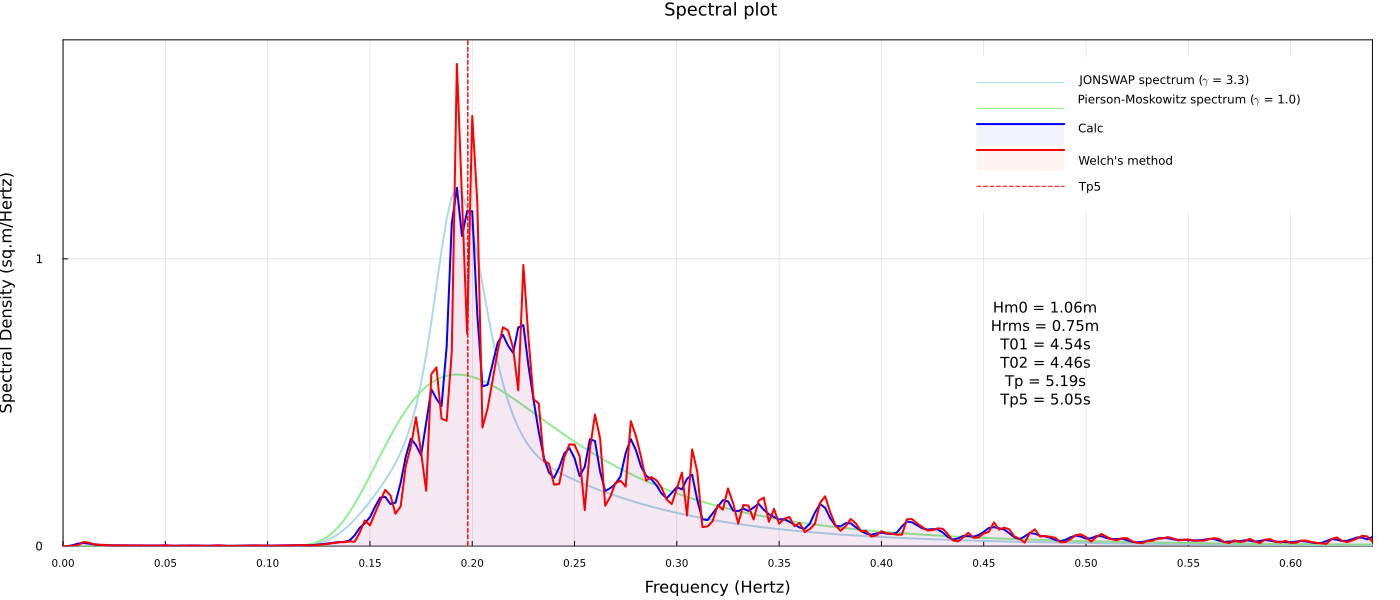

In [158]:
## Julia program to read a selected .HXV file and display 30-minute time series plots
## JW December 2022
#using ContinuousWavelets 
using CSV
using Dates, DataFrames, Distributions , DSP
using Gtk
using LaTeXStrings
using NativeFileDialog
using Plots
using Printf
using Statistics #, StatsPlots


################################################
################################################
##           START OF MAIN PROGRAM
################################################
################################################

# Widen screen for better viewing
display("text/html", "<style>.container { width:100% !important; }</style>")

# Select a HVA or BVA file
infil = pick_file(filterlist="HXV");
println("Selected ",infil)

df = DataFrame(CSV.File(infil,header=0, delim=","));

## Calculate WSEs

function get_displacements(arry)
    displacements = []

    if length(arry[1]) == 3
    
        for i in arry
            append!(displacements,parse(Int, SubString.(i, 1, 1), base=16)*16^2 + parse(Int, SubString.(i, 2, 2), base=16)*16^1 + parse(Int, SubString.(i, 3, 3), base=16)*16^0)
        end
        
    else
        
        for i in arry
            append!(displacements,parse(Int, SubString.(i, 1, 1), base=16)*16^1 + parse(Int, SubString.(i, 2, 2), base=16)*16^0)
        end
        
    end

    displacements[findall(>=(2048), displacements)] = 2048 .- displacements[findall(>=(2048), displacements)];
    
    return(displacements./100)
    
end


function spike_value(wse)
#####################################    
    median_value = median(wse)
    std_value = std(wse)

    return(median_value + 3*std_value)

    end    # spike_value()


function do_fft(heave, N)
################################################
# calculate the Fourier coefficients vide (5.6.2)
    return([sum([heave[k]*exp(2*pi*-1im*k*l/N) for k in (1:N)]) for l in (1:N)])
end    # do_fft()


function calc_psd(Hl, N)
################################################
# The power spectral density is obtained from the Fourier coefficients    
    PSD = zeros(trunc(Int,N/2))

    for l = 1:trunc(Int,N/2)   
        if (l==1) || (l==trunc(Int,N/2)-1)
            PSD[l] = abs(Hl[l])^2
        else
            PSD[l] = abs(Hl[l])^2+abs(Hl[N-l-1])^2
        end
    end

    # Smooth coefficients vide (5.6.6)
    PSD_smooth = PSD
    [PSD_smooth[i] = PSD[i-1]/4 + PSD[i]/2 + PSD[i+1]/4 for i in (2:trunc(Int,N/2)-1)]

    return(PSD_smooth)
end    # calc_psd()


function calc_tp5(f2,Sf)
##########################################
# Calculate Tp5 via Read method
    Sf_max = maximum(Sf)

    numerator = 0; denominator = 0

    Sf_sum = cumsum(Sf.*Sf_max).^5

    for i in 1:length(f2)
        w = Sf[i] / Sf_max
        numerator +=  f2[i] * w^5
        denominator += w^5
    end

    Fp5 = numerator / denominator
    
    return(Fp5)    # calc_tp5()

    end    # calc_tp5()


function calc_hm0(Sf,freq)
##########################################    
    ax1 = (last(freq) - first(freq)) / (length(freq)-1)

    # calc spectral moments m0, m1, m2, m3, and m4
    s00 = 0; m0 = 0

    for ii in 1:128

        s00 += freq[ii]^0 * Sf[ii];

    end

    m0 = 0.5*ax1*(first(freq)^0*first(Sf) + 2*s00 + last(freq)^0*last(Sf))

    return(4 * m0^0.5)

    end    # calc_hm0()


function calculate_frequency_domain_parameters(f2, spectra)
##########################################
# Calculate frequency-domain parameters    
# Calls: calc_tp5()
    ax1 = (last(f2) - first(f2)) / (length(f2)-1)

    # calc spectral moments m0, m1, m2, m3, and m4
    s00 = 0; s01 = 0; s02 = 0; s03 = 0; s04 = 0;
    m0 = 0; m1 = 0; m2 = 0; m3 = 0; m4 = 0

    for ii in 1:128

        s00 += f2[ii]^0 * spectra[ii]
        s01 += f2[ii]^1 * spectra[ii]
        s02 += f2[ii]^2 * spectra[ii]
        s03 += f2[ii]^3 * spectra[ii]
        s04 += f2[ii]^4 * spectra[ii]

    end

    m0 = 0.5*ax1*(first(f2)^0*first(spectra) + 2*s00 + last(f2)^0*last(spectra))
    m1 = 0.5*ax1*(first(f2)^1*first(spectra) + 2*s01 + last(f2)^1*last(spectra))
    m2 = 0.5*ax1*(first(f2)^2*first(spectra) + 2*s02 + last(f2)^2*last(spectra))
    m3 = 0.5*ax1*(first(f2)^3*first(spectra) + 2*s03 + last(f2)^3*last(spectra))
    m4 = 0.5*ax1*(first(f2)^4*first(spectra) + 2*s04 + last(f2)^4*last(spectra))

    ##println("m0 = ",m0," m1 = ",m1, " m2 = ",m2, " m3 = ",m2, " m4 = ",m4)

    # calc wave parameters Hm0, Hrms, T01, T02, Tc
    Hm0 = 4*sqrt(m0)     # Tucker & Pitt p.32 (2.2-6b)
    Hrms = sqrt(8*m0)    # Goda 2nd. Edition p.262 (9.15)
    T01 = m0/m1          # Tucker & Pitt p.41 Table 2.2 
    T02 = sqrt(m0/m2)    # Tucker & Pitt p.40 (2.3-2)
    Tc = sqrt(m2/m4)     # Tucker & Pitt p.41 Table 2.2 - also see Notes

    # identify spectral peak and frequency as peak
    Fp = f2[argmax(spectra)]
    Tp = 1/Fp
    fp5 = calc_tp5(f2, spectra)
    Tp5 = 1/fp5

    # calculate spectral width vide Tucker and Pitt p.85 (5.2-8)
    # Note: for JONSWAP, v = 0.39; for PM, v = 0.425
    v = (m0*m2 / m1^2 - 1)^0.5

    # calculate Skewness vide Tucker and Pitt p.109 (5.5-17)
    Skewness = (m0^2 * m3/m1^3 - 3*v^2 - 1) / v^3;
    
    return(Hm0, Hrms, T01, T02, Tc, Tp, fp5, Tp5, Skewness)
    
    end    # calculate_frequency_domain_parameters()


function calc_representative_spectra(frequency,Hm0,Tp,gamma)
##########################################    
    """
    function to calculate representative spectrum based on the Jonswap formula in Tucker and Pitt p.339 (10.3-9a)

    inputs:
        frequency - array of spectral frequencies
        Hm0 - floating point value
        Tp - floating point value
        gamma - floating point value - Peak ehhancement factor (Enter 1 for PM, or 3.3 for Jonswap)

        Typical calls:
        Spectra_PM = calc_representative_spectra(f2, Hm0, Tp, 1.0)
        Spectra_JONSWAP = calc_representative_spectra(f2, Hm0, Tp, 3.3)

    returns:
        Sf - array of representative spectra        
    """

    alpha = 1    # initial Philips constant (will decrease for each iteration required)
    g = 9.81
    fp = 1/Tp    # peak frequency

    hm0 = 99.    # set this to large value (so it will change on first iteration)

    Sf = [];

    while((Hm0 - hm0) <= 0.0005)

        Sf = vcat([alpha*g^2 * (2*pi)^-4 * ff^-5 * exp(-1.25 * (ff/fp)^-4) * gamma^exp(-(ff-fp)^2/(2*0.07^2 * fp^2)) for ff in frequency[findall(<=(fp), frequency)]],
                [alpha*g^2 * (2*pi)^-4 * ff^-5 * exp(-1.25 * (ff/fp)^-4) * gamma^exp(-(ff-fp)^2/(2*0.09^2 * fp^2)) for ff in frequency[findall(>(fp), frequency)]]);
        Sf[1] = 0;

###################################################################################################################################            
###  See discussion at https://stackoverflow.com/questions/44915116/how-to-decide-between-scipy-integrate-simps-or-numpy-trapz  ###
###################################################################################################################################

        ##        hm0 = 4*(np.trapz(Sf, frequency))^0.5    # calculate new Hm0 based on Sf values
        hm0 = calc_hm0(Sf,frequency);   # see https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.integrate.simps.html        
        alpha *= 0.95;    # reduce alpha by 5% so iterations approach a limit of 0.0005

    end

    return(Sf)    # calc_representative_spectra()
        
    end    # calc_representative_spectra()


function plot_spectra(heave)
################################################
   # MkIII parameters
    N = 512
    Sample_frequency = 1.28
    dt = 1/Sample_frequency

    # calc window
    w = DSP.Windows.hanning(N)
    w_norm = sqrt(Sample_frequency*sum(w.^2))

    start = 0
    segments = []

    # Do spectral analysis for 9 individual segments of 512 water surface elevations
    for segment in (1:8)
        finish = start+N

        # calculate the Fourier coefficients vide (5.6.2)
        Hl = do_fft(heave[start+1:finish].*w./w_norm, N)

        # calculate power spectral density
        Pden = calc_psd(Hl, N);
        segments = [segments;Pden]

        # set start for next segment
        start = start + 256
    end 

    # convert vector to matrix of 9 individual 256-value spectra
    combined_segments = reshape(segments,256,8);
    global Pden = mean.(eachrow(combined_segments))

    global freqs = [0:1:N/2-1;]*Sample_frequency/N

    global ps_w = welch_pgram(heave, 512, 256; onesided=true, nfft=512, fs=Sample_frequency, window=hanning);
    global f2 = freq(ps_w);
    global Pden2 = power(ps_w);

    freqs = [1:1:N/2;]*Sample_frequency/N

    Hm0, Hrms, T01, T02, Tc, Tp, fp5, Tp5, Skewness = calculate_frequency_domain_parameters(f2, Pden2)
    @printf("%s; Hm0 = %5.2fm; Hrms = %5.2fm; T01 = %5.2fs; T02 = %5.2fs; Tc = %5.2fs; Tp = %5.2fs; Tp5 = %5.2fs; Skewness = %5.4f",
        Dates.format(start_date, "yyyy-mm-dd HH:MM"),Hm0, Hrms, T01, T02, Tc, Tp, Tp5, Skewness)
    
    # Calculate representative spectra for P-M and JONSWAP
    Spectra_PM = calc_representative_spectra(f2, Hm0, Tp, 1.0);
    Spectra_JONSWAP = calc_representative_spectra(f2, Hm0, Tp, 3.3);

    # determing maximum y-axis value for spectral plots
    max_y = maximum([maximum(Pden),maximum(Pden2),maximum(Spectra_JONSWAP)]) * 1.05
    if max_y < 0.1
        tick_val = 0.01
    elseif  max_y < 1
        tick_val = 0.1
    elseif max_y < 10
        tick_val = 1   
    else
        tick_val = 5
    end

    # Plot the representative spectra
    p_spectra = plot(f2,Spectra_JONSWAP, lw=2, c=:lightblue, label="JONSWAP spectrum (" * L"\gamma" * " = 3.3)")
    p_spectra = plot!(f2,Spectra_PM, lw=2, c=:lightgreen, label="Pierson-Moskowitz spectrum (" * L"\gamma" * " = 1.0)\n")
    
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
    # Add frequency-domain parameters to plot
    x_lim = xlims(p_spectra)[1]; y_lim = ylims(p_spectra)[2]
    p_spectra = annotate!(x_lim*-25, y_lim*0.65, "Hm0 = " * string(round(Hm0, digits=2)) * "m",annotationfontsize=10) 
    p_spectra = annotate!(x_lim*-25, y_lim*0.60, "Hrms = " * string(round(Hrms, digits=2)) * "m") 
    p_spectra = annotate!(x_lim*-25, y_lim*0.55, "T01 = " * string(round(T01, digits=2)) * "s") 
    p_spectra = annotate!(x_lim*-25, y_lim*0.50, "T02 = " * string(round(T02, digits=2)) * "s") 
    p_spectra = annotate!(x_lim*-25, y_lim*0.45, "Tp = " * string(round(Tp, digits=2)) * "s") 
    p_spectra = annotate!(x_lim*-25, y_lim*0.40, "Tp5 = " * string(round(Tp5, digits=2)) * "s") 
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
    
    
    # plot calculated spectra
    p_spectra = plot!(freqs, Pden, label="Calc\n", 
        c="blue", lw=2, fillrange = 0, fillalpha = 0.05, fillcolor = :blue)
        
    # plot Welch's spectra
    p_spectra = plot!(f2, Pden2, label="Welch's method", 
        c="red", lw=2, fillrange = 0, fillalpha = 0.05, fillcolor = :red)
    
    p_spectra = vline!([fp5; fp5], lw=1, ls =:dash, c=:red, label="Tp5")
    
    plot_spc = Plots.plot(p_spectra, layout = (1, 1), size = (1400, 600), framestyle = :box, 
            xlim=(0,0.64),  xticks = 0:0.05:1.28, xtickfontsize=7, ytickfontsize=8, xlabel="Frequency (Hertz)",
            ylim=(0,max_y), yticks=0:tick_val:max_y, ylabel="Spectral Density (sq.m/Hertz)",
            fg_legend=:transparent, title = " Spectral plot", titlefontsize=12,
            grid=true, gridlinewidth=0.5, gridalpha=1, foreground_color_grid="lightgrey", margin = 5Plots.mm)            

    display(plot_spc)
    
end


# Calculate sequence numbers
arry = SubString.(df.Column1, 3, 4)

sequence = []

for i in arry
    append!(sequence,parse(Int, SubString.(i, 1, 1), base=16)*16^1 + parse(Int, SubString.(i, 2, 2), base=16)*16^0)
end

# Calculate heave WSEs
arry = SubString.(df.Column3, 1, 3);
heave = get_displacements(arry);

# Calculate north WSEs
arry = SubString.(df.Column3, 4, ) .* SubString.(df.Column4, 1, 2)
north = get_displacements(arry);

# Calculate north WSEs
arry = SubString.(df.Column4, 3, 4) .* SubString.(df.Column5, 1, 1)
west = get_displacements(arry);

spike = spike_value(heave)
heave_spikes = findall(i->(i>=spike), abs.(heave));

spike = spike_value(north)
north_spikes = findall(i->(i>=spike), abs.(north));

spike = spike_value(west)
west_spikes = findall(i->(i>=spike), abs.(west));

# time stamp each WSE
points = collect(0:1:length(heave)-1)/1.28
times = []

#start_date = DateTime.(split(split(infil,"}")[2],".")[1], "yyyy-mm-ddTHHhMMZ")
fl_length = length(split(infil,".")[1]);
start_date = DateTime.(infil[fl_length-16:fl_length-1], "yyyy-mm-ddTHHhMM")
infil[fl_length-16:fl_length-1]
for i in 1:length(points)
    push!(times,unix2datetime(datetime2unix(start_date) + points[i]))
end

# create plots of heave, north, and west
title_string = Dates.format(start_date, "dd/mm/yyyy HH:MM") * " UTC"
p1_hnw = plot(times,heave, label="", c="#4a536b", lw=0.5, title=title_string, titlefontsize=12, ylabel="Heave") ##last(split(infil,"\\")))

# get plotting limits
x_lim1 = xlims(p1_hnw)[1]; y_lim1 = ylims(p1_hnw)[1]
x_lim2 = xlims(p1_hnw)[2]; y_lim2 = ylims(p1_hnw)[2]

#p2_hnw = scatter(times[north_spikes], north[north_spikes], label="", markershape=:circle, ms=4, mc=:white, ma=1, msc=:red, msa=0.25, msw=0.5)
p2_hnw = plot(times,north, label="", ylabel="North", c="#aed6dc", lw=0.5)
#p3_hnw = scatter(times[west_spikes], west[west_spikes], label="", markershape=:circle, ms=4, mc=:white, ma=1, msc=:red, msa=0.25, msw=0.5)
p3_hnw = plot(times,west, label="", ylabel="West", c="#ff9a8d", lw=0.5)

hline!(p1_hnw, [0], lw=1, label="")
hline!(p2_hnw, [0], lw=1, label="")
hline!(p3_hnw, [0], lw=1, label="")

# get plotting limits
x_lim1 = xlims(p1_hnw)[1]; y_lim1 = ylims(p1_hnw)[1]
x_lim2 = xlims(p1_hnw)[2]; y_lim2 = ylims(p1_hnw)[2]

# display plots to screen
plot_wse = Plots.plot(p1_hnw, p2_hnw, p3_hnw, layout = (3, 1), size = (1400, 600),
    xlim=(first(times),last(times)),  xticks = first(times):Minute(5):last(times),xtickfontsize=7,ytickfontsize=8,
    framestyle = :box,fg_legend=:transparent, legend=:bottomleft,
    leftmargin = 15Plots.mm, grid=true, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1)            

display(plot_wse)

# need to adjust length of heave so that it is 2304 points
if length(heave) < 2304
    append!(heave,zeros(2304-length(heave)))
elseif length(heave) > 2304
    heave = heave[1:2304]
else
    
end
plot_spectra(heave)

In [161]:
using ContinuousWavelets, Wavelets

fs = 1.28
n = length(heave)

t = times
f = f2;

c = wavelet(Morlet(π), β=2);

# plotting
res = ContinuousWavelets.cwt(heave, c)
freqs = getMeanFreq(ContinuousWavelets.computeWavelets(n, c)[1])
freqs[1] = 0

#display("text/html", "<style>.container { width:100% !important; }</style>")

# get title string for plot
title_str = split(splitdir(infil)[2],".")[1]

gr()

p1 = contourf(t, freqs, abs.(res)', c=cgrad(:Spectral,rev=true), colorrange=(0, maximum(real(res))), levels=5,
    xtickfont = :serif,titlefontsize=13, ytickfont=:serif,
    xlabel= "Date (EST)", ylabel= "Period (seconds)", colorbar=false, framestyle = :box)
hline!(25:25:275,c="white",lw=0.5,label="")
#vline!(xmin:Dates.Hour(6):xmax,c="white",lw=0.5,label="")
    
plot(p1,size=(1400, 600), xminorticks=12, tickdir=:out, xtickfontvalign = :bottom, ytickfonthalign = :left, margin = 15Plots.mm, )

┌ Warning: the lowest frequency wavelet has more than 1% its max at zero, so it may not be analytic. Think carefully
│   lowAprxAnalyt = 0.064125
└ @ ContinuousWavelets C:\Users\Jim\.julia\packages\ContinuousWavelets\arobh\src\sanityChecks.jl:7
┌ Warning: the lowest frequency wavelet has more than 1% its max at zero, so it may not be analytic. Think carefully
│   lowAprxAnalyt = 0.064125
└ @ ContinuousWavelets C:\Users\Jim\.julia\packages\ContinuousWavelets\arobh\src\sanityChecks.jl:7


┌ Warning: the lowest frequency wavelet has more than 1% its max at zero, so it may not be analytic. Think carefully
│   lowAprxAnalyt = 0.052491
└ @ ContinuousWavelets C:\Users\Jim\.julia\packages\ContinuousWavelets\arobh\src\sanityChecks.jl:7


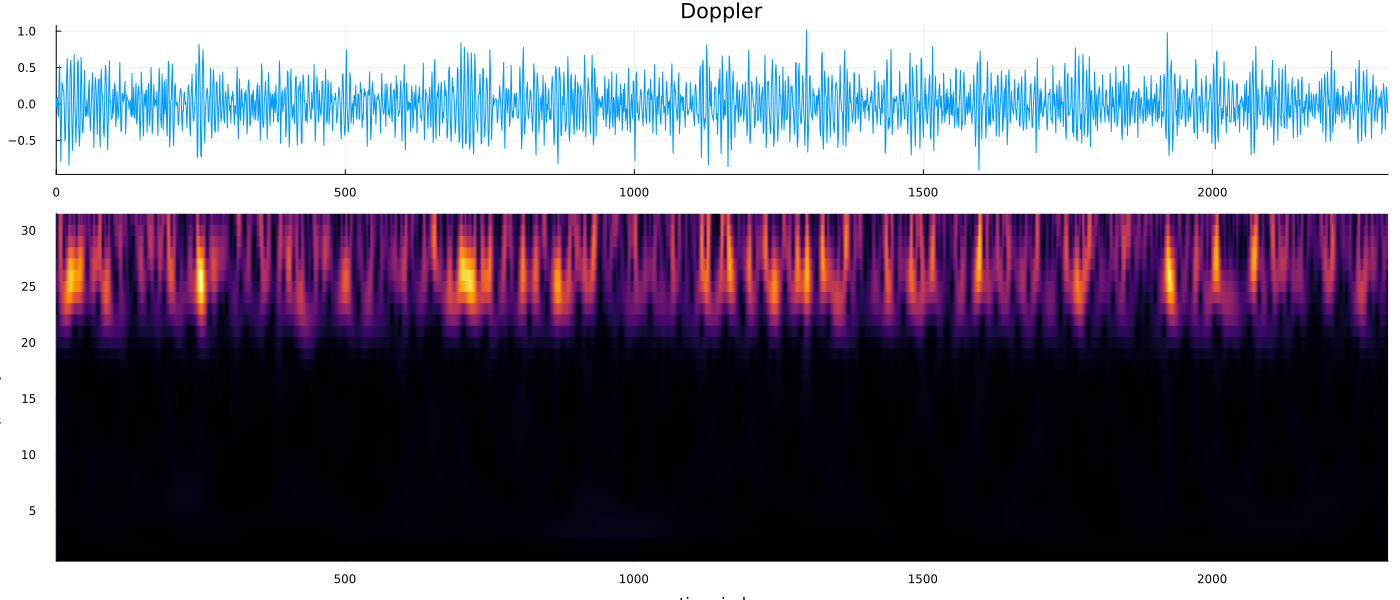

In [177]:
using ContinuousWavelets, Plots, Wavelets, FFTW
n=length(heave);
f = heave;

p1=plot(0:1:n-1 ./ 1.28,f,legend=false,title="Doppler",xlims=(0,n));

c = wavelet(Morlet(π), averagingType=NoAve(), β=2);
res = ContinuousWavelets.cwt(f, c)
p2=heatmap(abs.(res)', xlabel= "time index",
    ylabel="frequency index",colorbar=false, size=(1400, 600));

l=@layout [a{.3h};b{.7h}]
plot(p1,p2,layout=l)

In [171]:
length(f)

2304

In [173]:
1:1:n ./ 1.28

1.0:1.0:1800.0